## Analisis Exploratorio de Datos (EDA) - Airbnb Ciudad de Mexico

Este notebook tiene como objetivo explorar las dataset extraidos de MongoDB para comprender su estructura, calidad y posibles transformaciones necesarias antes de descargarlos en un Data Warehouse.

Se analizaran las siguientes colecciones:
- Listings
- Reviews
- Calendar

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.extraccion import Extraccion

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Datos de conexión a MongoDB
uri = "mongodb://localhost:27017/"
database = "MX_DB"

# Crear instancia de la clase con los parámetros correctos
extraccion = Extraccion(uri=uri, database=database)

# Conectarse explícitamente antes de extraer los datos
extraccion.conectar_mongodb()

#extraccion = Extraccion()
df_listings = extraccion.obtener_datos('MX_listings')
df_reviews = extraccion.obtener_datos("MX_reviews")
df_calendar = extraccion.obtener_datos('MX_calendar') 

#------Primeras filas-----

df_listings.head()
df_reviews.head()
df_calendar.head()

#-----Dimensiones--------

print("Listings:", df_listings.shape)
print("Reviews:", df_reviews.shape)
print("Calendar:", df_calendar.shape)

#-------Tipos de datos----

df_listings.info()
df_reviews.info()
df_calendar.info()

#------Valores nulos------

df_listings.isnull().sum()
df_reviews.isnull().sum()
df_calendar.isnull().sum()

# --- Detección y corrección de columnas no hasheables en df_listings ---


# Identificar columnas con listas o diccionarios
cols_invalidas = [
    col for col in df_listings.columns 
    if df_listings[col].apply(lambda x: isinstance(x, (list, dict))).any()
]

if cols_invalidas:
    print(f"Columnas con listas o diccionarios en df_listings: {cols_invalidas}")
    # Convertir esas columnas a texto solo para poder buscar duplicados
    df_listings_temp = df_listings.copy()
    for col in cols_invalidas:
        df_listings_temp[col] = df_listings_temp[col].astype(str)
else:
    df_listings_temp = df_listings

# Contar duplicados de forma segura

#------Duplicados-------
        
print("Listings duplicados:", df_listings_temp.duplicated().sum())
print("Reviews duplicados:", df_reviews.duplicated().sum())
print("Calendar duplicados:", df_calendar.duplicated().sum())

Conexion exitosa: MX_DB
Extraccion 'MX_listings' (459 registros)
Extraccion 'MX_reviews' (210359 registros)
Extraccion 'MX_calendar' (869428 registros)
Listings: (459, 77)
Reviews: (210359, 7)
Calendar: (869428, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 77 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   _id                                           459 non-null    object        
 1   id                                            459 non-null    int64         
 2   listing_url                                   459 non-null    object        
 3   scrape_id                                     459 non-null    int64         
 4   last_scraped                                  459 non-null    datetime64[ns]
 5   source                                        459 non-null    object        
 6   name               

## Conclusiones del Analisis I

- Conexión: Exitosa a la base de datos airbnb.

- Tamaño de los datasets:

    - listings: 26.401 registros y 77 columnas.
    - reviews: 1.388.226 registros y 7 columnas.
    - calendar: 9.636.365 registros y 6 columnas.

- Duplicados: No se detectaron duplicados en ninguna colección.

- Valores nulos:

En listings, varias columnas de host e información descriptiva tienen nulos (host_about, neighborhood_overview, review_scores_*), lo que indica posibles campos opcionales.

En reviews y calendar, no hay nulos significativos.

- Tipos de datos: Las fechas están correctamente como datetime64, y los precios aún deben limpiarse (actualmente son object).

- Columnas con estructuras anidadas:
host_verifications y amenities son listas → podrían requerir desanidado o conteo de elementos más adelante.

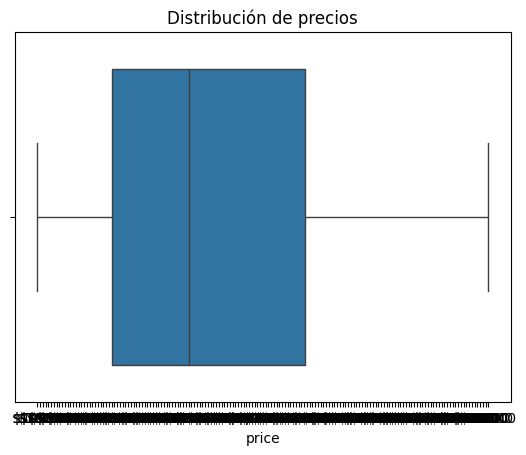

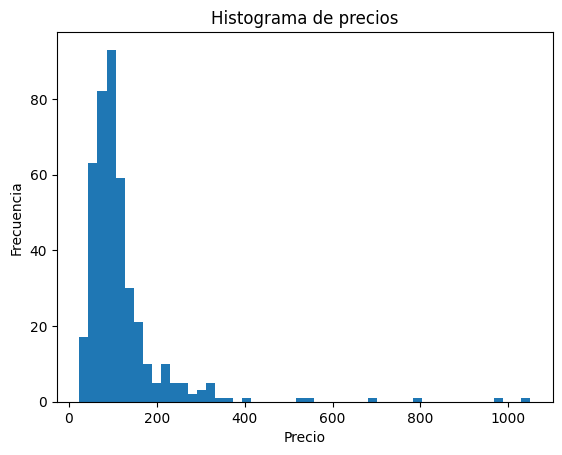

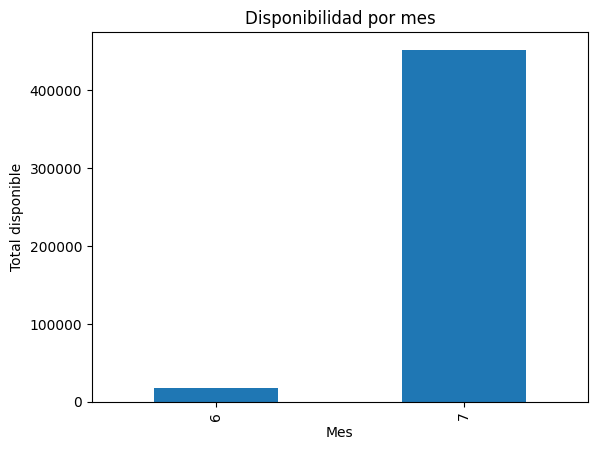

In [4]:

#-----Boxplot de precios-----

sns.boxplot(x=df_listings_temp['price'])
plt.title("Distribución de precios")
plt.show()

#-----Estadisticas descriptivas-----

df_listings_temp[['price', 'minimum_nights', 'availability_365']].describe()

#------Campos anidados-----

df_listings_temp['amenities'].head()

#-----Agrupacion por mes-----
df_calendar['date']= pd.to_datetime(df_calendar['date'])
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar.groupby('month')['available'].sum()

#------Limpieza de datos-----
#df_listings['price'] = df_listings['price'].replace('[\$,]', '', regex=True).astype(float)
df_listings_temp['price'] = (
    df_listings_temp['price']
    .astype(str)  # asegúrate de que todo sea string
    .replace(r'[\$,]', '', regex=True)
    .replace('', '0')  # reemplaza vacíos por 0 para evitar errores
    .astype(float)
)

#--------Histograma de precios--------
plt.hist(df_listings_temp['price'], bins=50)
plt.title("Histograma de precios")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

#--------Disponibilidad por mes---------
df_calendar.groupby('month')['available'].sum().plot(kind='bar')
plt.title("Disponibilidad por mes")
plt.xlabel("Mes")
plt.ylabel("Total disponible")
plt.show()


## Conclusiones del Analisis II

- La mayoría de los precios se concentran en valores bajos, con algunos outliers que podrían corresponder a alojamientos de lujo o errores de registro.  
- Los meses con menor disponibilidad (ej. junio-julio) pueden indicar alta demanda en temporada vacacional.  
- El dataset contiene columnas con listas (`amenities`, `host_verifications`) que deben ser transformadas si se desea un análisis más profundo.  
- Tras la limpieza y validación, los datos están listos para un análisis avanzado o modelado predictivo.


# Hallazgos del EDA

- La columna `price` contiene símbolos que deben limpiarse para convertir a tipo numérico.
- Se detectaron valores extremos en `minimum_nights`, algunos con más de 1000 noches.
- `amenities` es una lista que puede expandirse en columnas binarias para análisis.
- El campo `date` en `calendar` puede usarse para derivar mes, año y trimestre.
- Existen valores nulos en varias columnas que deben tratarse en la fase de transformación.